In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2

In [21]:
plt.rcParams['figure.figsize'] = [6, 8]

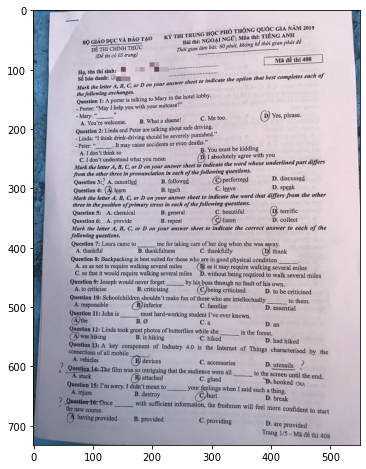

In [22]:
img = cv2.imread('exam2.png')
plt.imshow(img, cmap='gray')

In [23]:
def perspective_transform(img, tmatrix, output_size, flags=cv2.INTER_LINEAR, save_result=None):
    dst = cv2.warpPerspective(img, tmatrix, output_size, flags=flags)
    if save_result:
        cv2.imwrite(save_result, dst)
        print(f"Saved output image to {save_result}")
    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1), plt.imshow(img[...,::-1]), plt.title("original")
    plt.subplot(1, 2, 2), plt.imshow(dst[...,::-1]), plt.title("translated")
    plt.show()

In [24]:
# Transformation ảnh về cùng một hình thái
h, w, _ = img.shape
pts1 = np.float32([[27, 2], [540, 0], [2, 720], [540, 730]])
pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
M = cv2.getPerspectiveTransform(pts1, pts2)
img = cv2.warpPerspective(img, M, (w,h))

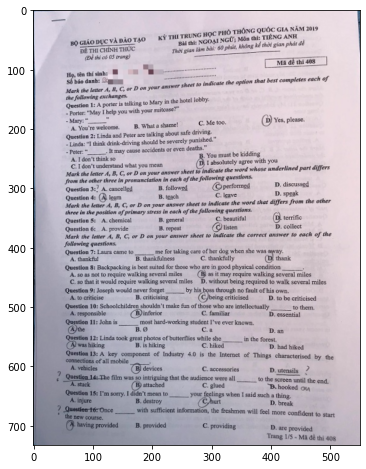

In [25]:
plt.imshow(img)

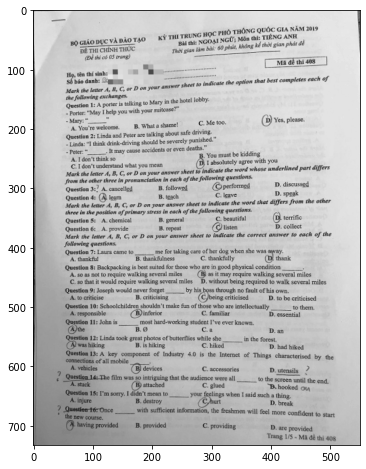

In [26]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [27]:
# blurred = cv2.GaussianBlur(img, (5, 5), 0)
# plt.imshow(blurred, cmap='gray')

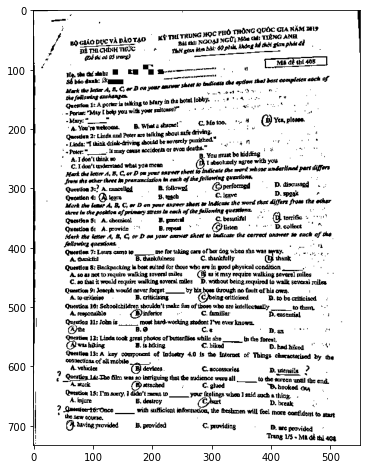

In [28]:
# Chuyển thành ảnh đen trắng bằng Gaussian Threshold 
# (với những phép toán như tìm contour hoặc binary_fill_holes sẽ xử lý hiệu quả hơn trên ảnh đen trắng nên cần có bước này)
im = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
plt.imshow(im, cmap='gray')

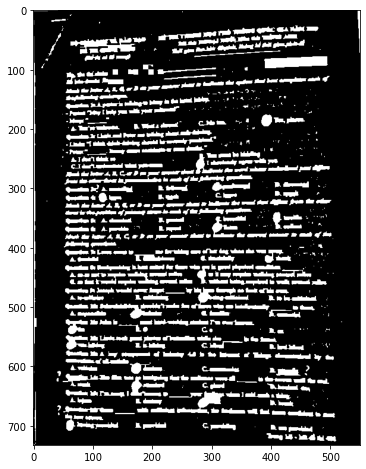

In [29]:
# lấp chỗ trống trong những hình tròn
from scipy.ndimage.morphology import binary_fill_holes

# binary_fill_holes là 1 hàm binary delation
clean_image = binary_fill_holes(255 - im)
plt.imshow(clean_image, cmap='gray')

In [30]:
clean_image = np.float32(clean_image)

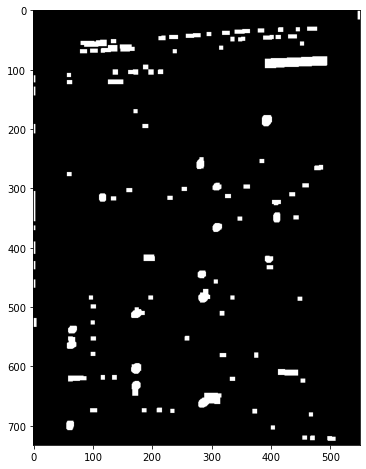

In [31]:
# Opening (mục đích để loại bỏ trường hợp 2 hình tròn dính nhau, hoặc hình tròn dính vào chữ, 
# tuy nhiên opening làm mất dấu khi các hình tròn bị gạch chéo)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
opening = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

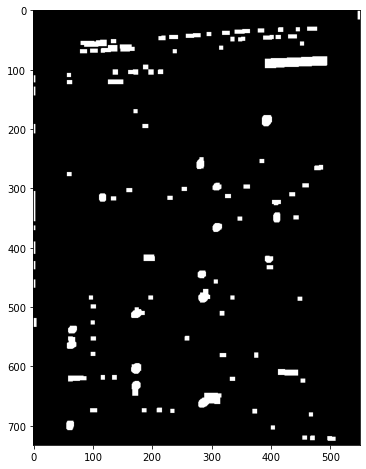

In [40]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
dilation = cv2.dilate(opening, kernel, iterations=1)
plt.imshow(dilation, cmap='gray')

In [41]:
# Lấy ra vị trí các contour (contour là 1 chuỗi tọa độ (x_i, y_) các điểm có cùng độ sáng dọc theo biên của 1 object (t đang hiểu là thế))
contours, _ = cv2.findContours(dilation.astype(np.uint8), # pylint: disable=unused-variable
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_NONE)

# Vẽ contour
obj_image = np.zeros(dilation.shape)
for index, cnt in enumerate(contours):
    print(cnt.shape)
    print(cnt)
    cv2.drawContours(dilation, [cnt], 0, 255, -1)

(38, 1, 2)
[[[495 718]]

 [[495 719]]

 [[495 720]]

 [[495 721]]

 [[495 722]]

 [[495 723]]

 [[495 724]]

 [[496 725]]

 [[497 725]]

 [[498 725]]

 [[499 725]]

 [[500 725]]

 [[501 725]]

 [[502 725]]

 [[503 725]]

 [[504 725]]

 [[505 725]]

 [[506 725]]

 [[507 725]]

 [[508 725]]

 [[508 724]]

 [[508 723]]

 [[508 722]]

 [[508 721]]

 [[508 720]]

 [[508 719]]

 [[507 719]]

 [[506 719]]

 [[505 719]]

 [[504 719]]

 [[503 719]]

 [[502 718]]

 [[501 718]]

 [[500 718]]

 [[499 718]]

 [[498 718]]

 [[497 718]]

 [[496 718]]]
(27, 1, 2)
[[[467 717]]

 [[466 718]]

 [[466 719]]

 [[466 720]]

 [[466 721]]

 [[466 722]]

 [[466 723]]

 [[466 724]]

 [[467 724]]

 [[468 724]]

 [[469 724]]

 [[470 724]]

 [[471 724]]

 [[472 724]]

 [[473 724]]

 [[473 723]]

 [[473 722]]

 [[473 721]]

 [[473 720]]

 [[473 719]]

 [[473 718]]

 [[473 717]]

 [[472 717]]

 [[471 717]]

 [[470 717]]

 [[469 717]]

 [[468 717]]]
(26, 1, 2)
[[[453 717]]

 [[453 718]]

 [[453 719]]

 [[453 720]]

 

Ta có công thức $\frac{4\pi^2r^2}{C^2}=1$ trong đó $C$ là chu vi của hình tròn, giờ ta xác định giá trị $\alpha=\frac{4\pi area}{P^2}$ với $P$ là chu vi của `contour` và nếu giá trị $\alpha$ lớn hơn hoặc bằng `round_thresh` thì ta chấp nhận `contour` đấy là vòng tròn. Ngoài ra trong ảnh các chữ cái cũng có thể tạo thành contour với `area` nhỏ, nên cần phải có một `threshold` nữa cho `area`

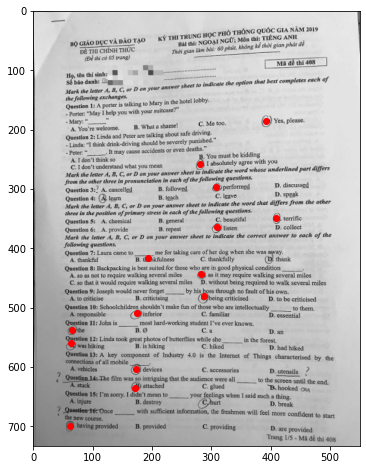

In [45]:
import matplotlib.pyplot as plt

round_thresh = 0.6

plt.figure()
height, width = dilation.shape
plt.imshow(img.astype(np.uint8), cmap='gray')
areas = []
alphas = []

# print('Object      Area Perimeter Roundness')
for ind, contour in enumerate(contours):
    # tính chu vi của contour
    perimeter = cv2.arcLength(contour, True)
    # tính diện tích của contour
    area = cv2.contourArea(contour)
    areas.append(area)
    
    # nếu như chu vi bằng 0 hoặc area nhỏ hơn threshold thì ta đặt ngay góc alpha = 0
    if perimeter==0 or area<140:
        alpha = 0
    else:
        alpha = 4*np.pi*area/(perimeter**2)
        alphas.append(alpha)

    # Vẽ vòng tròn đỏ tại tâm của contour thỏa mãn điều kiện là vòng tròn
    if alpha > round_thresh:
        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        if cy > 110:
            plt.plot(cx, cy, 'ro')

axes = plt.gca()
axes.set_xlim([0, width])
axes.set_ylim([height, 0])

plt.show()

In [39]:
n = 6
  
alphas.sort()
areas.sort() 
print(areas[-n:]) 
print(alphas[-n:])

[343.0, 377.0, 388.0, 756.5, 813.5, 1809.5]
[0.8576968418434273, 0.8619070471577287, 0.8621915770696059, 0.8755364705816544, 0.8876791231160799, 0.8939457709343694]
